In [237]:
import pandas as pd
import glob
import os
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import matplotlib.cm as cm

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

from matplotlib import cm


In [238]:
labels_path = "/neurospin/dico/rmenasria/Runs/03_main/Input/ABCD/ABCD_preterm_labels_light.csv"
base_path   = "/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation/embeddings/ABCD_embeddings/"

In [239]:
labels_df = pd.read_csv(labels_path, low_memory=False)
labels_df['src_subject_id'] = labels_df['src_subject_id'].str.replace("_","")

In [240]:
thresholds  = ["<27","27-32","32-37"]
threshold = thresholds[1]
region = "FCMpost-SpC_right"

In [241]:
embedding_file = None
for file in os.listdir(base_path):
    if file.startswith(region) and file.endswith(".csv"):
        embedding_file = file
        break
if embedding_file is None:
    raise FileNotFoundError(f"No embedding file found for region: {region}")

emb_path = os.path.join(base_path, embedding_file)
emb_df = pd.read_csv(emb_path)
emb_df['ID_clean'] = (
    emb_df['ID'].astype(str)
    .str.replace(r"^sub-", "", regex=True)
    .str.replace("_", "", regex=False)
)

df = emb_df.merge(
    labels_df,
    left_on='ID_clean', right_on='src_subject_id', how='inner'
)
df = df[df['prem_class'].isin([threshold, ">=37"])].copy()
df['y'] = (df['prem_class'] == threshold).astype(int)
X = df.filter(regex=r'^dim').values
y = df[['src_subject_id','y']]

In [242]:
# Ensure the labels and embeddings are aligned by printing the first few rows
print("First few rows of the merged DataFrame:")
print(df[['ID_clean', 'src_subject_id','prem_class', 'y']].head())



First few rows of the merged DataFrame:
          ID_clean   src_subject_id prem_class  y
0  NDARINV003RTV85  NDARINV003RTV85       >=37  0
1  NDARINV007W6H7B  NDARINV007W6H7B       >=37  0
2  NDARINV00BD7VDC  NDARINV00BD7VDC       >=37  0
3  NDARINV00HEV6HB  NDARINV00HEV6HB       >=37  0
4  NDARINV00J52GPG  NDARINV00J52GPG       >=37  0


In [243]:
# Construct nearest_neighbor matrix
nbrs = NearestNeighbors(n_neighbors=len(X)//2, algorithm='brute').fit(X)
distances, indices = nbrs.kneighbors()  


In [244]:
print(y)
#y.set_index('src_subject_id', inplace=True)

       src_subject_id  y
0     NDARINV003RTV85  0
1     NDARINV007W6H7B  0
2     NDARINV00BD7VDC  0
3     NDARINV00HEV6HB  0
4     NDARINV00J52GPG  0
...               ... ..
9979  NDARINVZZL0VA2F  0
9980  NDARINVZZLZCKAY  0
9981  NDARINVZZPKBDAC  0
9982  NDARINVZZZ2ALR6  0
9984  NDARINVZZZP87KR  0

[8737 rows x 2 columns]


In [245]:
label = "y"

In [246]:
def construct_average_nearest_neighbors(label_df):
    # Takes list of incides whose label is 1
    #label_red = label_df.reset_index()[[label]]
    #print(label_df.head())
    label_1 = label_df[label_df[label]==1].index.to_list()
    
    # In the indices matrix, put value of label corresponding to index
    neighbors = indices[:,1:]
    labels1 = np.in1d(neighbors, label_1)
    labels1 = labels1.reshape(neighbors.shape).astype(int)
    
    # Makes moving average along nearest neighbor
    labels1_cum = np.cumsum(labels1, axis=1)
    means_npy = np.zeros(labels1_cum.shape)
    for idx in range(len(labels1)):
        means_npy[idx,:] = labels1_cum[idx,:]/(np.arange(1, labels1_cum.shape[1]+1, 1).reshape(1,-1))
        
    return labels1, means_npy

In [247]:
def construct_average_distance_nearest_neighbors():

    # Makes moving average along nearest neighbor
    distances_cum = np.cumsum(distances[:,1:], axis=1)
    means_distance = np.zeros(distances_cum.shape)
    for idx in range(len(distances)):
        means_distance[idx,:] = distances_cum[idx,:]/(np.arange(1, distances_cum.shape[1]+1, 1).reshape(1,-1))
        
    return means_distance

In [248]:
y_df = df[['src_subject_id','y']].reset_index(drop=True)

In [249]:
labels1, means_npy = construct_average_nearest_neighbors(y_df)
means_distance = construct_average_distance_nearest_neighbors()

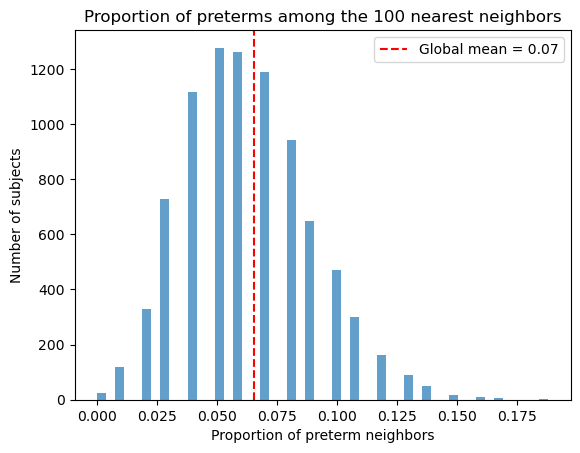

In [250]:
j = 100
mean_global = y_df['y'].mean()

plt.hist(means_npy[:, j], bins=50, alpha=0.7)
plt.axvline(mean_global, color='r', linestyle='--',
            label=f"Global mean = {mean_global:.2f}")
plt.title(f"Proportion of preterms among the {j} nearest neighbors")
plt.xlabel("Proportion of preterm neighbors")
plt.ylabel("Number of subjects")
plt.legend() 
plt.show()


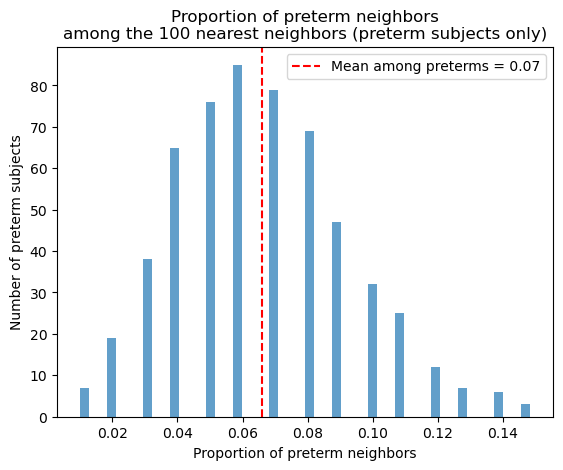

In [251]:
# Get the indices of preterm subjects
idx_preterm = np.where(y_df['y'].values == 1)[0]

# Choose neighborhood size
j = 100

# Extract the proportion of preterms among the j nearest neighbors of each preterm subject
props_preterm = means_npy[idx_preterm, j]

# Plot the histogram for preterm subjects only
plt.hist(props_preterm, bins=50, alpha=0.7)
plt.axvline(props_preterm.mean(), color='r', linestyle='--',
            label=f"Mean among preterms = {props_preterm.mean():.2f}")
plt.title(f"Proportion of preterm neighbors\namong the {j} nearest neighbors (preterm subjects only)")
plt.xlabel("Proportion of preterm neighbors")
plt.ylabel("Number of preterm subjects")
plt.legend()

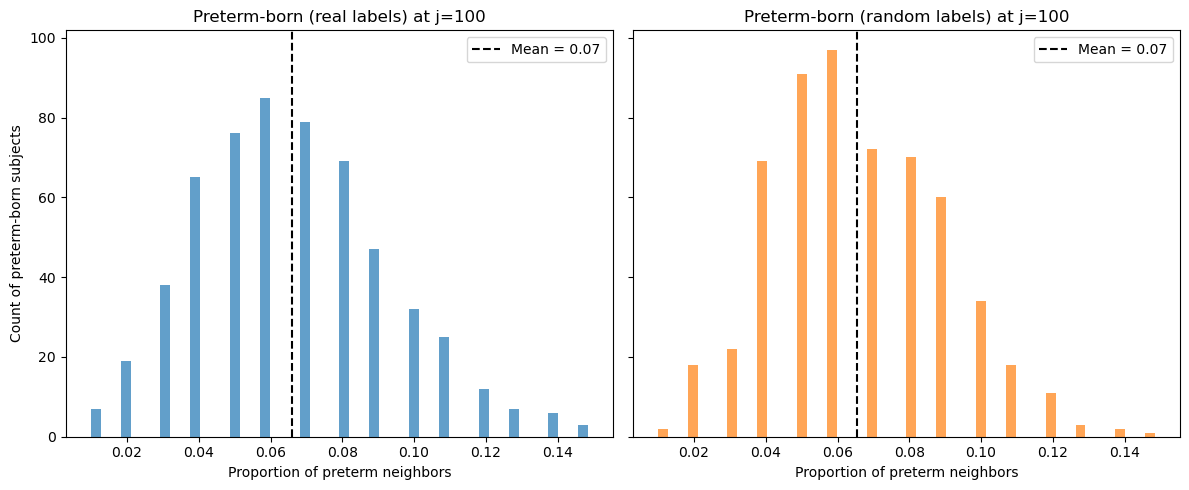

In [252]:
# Parameters
j = 100               
n_permutations = 1    # just one random draw

# Identify term‑born indices (y == 0)
y_values     = y_df['y'].values
idx_preterm     = np.where(y_values == 1)[0]

# Real proportions for term‑born
props_preterm_real = means_npy[idx_preterm, j]

# Single random permutation and its proportions for term‑born
rand_labels     = np.random.permutation(y_values)
rand_df         = pd.DataFrame({'y': rand_labels})
_, means_rand   = construct_average_nearest_neighbors(rand_df)
props_preterm_rand = means_rand[idx_preterm, j]

# Plot side‑by‑side histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Left: real labels
axes[0].hist(props_preterm_real, bins=50, alpha=0.7, color='C0')
axes[0].axvline(props_preterm_real.mean(), color='k', linestyle='--',
                label=f"Mean = {props_preterm_real.mean():.2f}")
axes[0].set_title(f"Preterm‑born (real labels) at j={j}")
axes[0].set_xlabel("Proportion of preterm neighbors")
axes[0].set_ylabel("Count of preterm‑born subjects")
axes[0].legend()

# Right: random labels
axes[1].hist(props_preterm_rand, bins=50, alpha=0.7, color='C1')
axes[1].axvline(props_preterm_rand.mean(), color='k', linestyle='--',
                label=f"Mean = {props_preterm_rand.mean():.2f}")
axes[1].set_title(f"Preterm‑born (random labels) at j={j}")
axes[1].set_xlabel("Proportion of preterm neighbors")
axes[1].legend()

plt.tight_layout()
plt.show()


## Cluster identification among all preterm subjects in the ABCD cohort

Cluster 0: 8 preterm subjects out of 216 (3.70%)
Cluster 1: 16 preterm subjects out of 189 (8.47%)
Cluster 2: 10 preterm subjects out of 224 (4.46%)
Cluster 3: 13 preterm subjects out of 242 (5.37%)
Cluster 4: 13 preterm subjects out of 248 (5.24%)
Cluster 5: 20 preterm subjects out of 216 (9.26%)
Cluster 6: 19 preterm subjects out of 165 (11.52%)
Cluster 7: 13 preterm subjects out of 221 (5.88%)
Cluster 8: 18 preterm subjects out of 224 (8.04%)
Cluster 9: 12 preterm subjects out of 247 (4.86%)
Cluster 10: 11 preterm subjects out of 263 (4.18%)
Cluster 11: 17 preterm subjects out of 200 (8.50%)
Cluster 12: 21 preterm subjects out of 259 (8.11%)
Cluster 13: 12 preterm subjects out of 187 (6.42%)
Cluster 14: 13 preterm subjects out of 225 (5.78%)
Cluster 15: 16 preterm subjects out of 219 (7.31%)
Cluster 16: 9 preterm subjects out of 184 (4.89%)
Cluster 17: 13 preterm subjects out of 193 (6.74%)
Cluster 18: 16 preterm subjects out of 193 (8.29%)
Cluster 19: 11 preterm subjects out of 178

/tmp/ipykernel_428767/2222614476.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_stats.index, y=cluster_stats['preterm_rate'],palette='viridis')


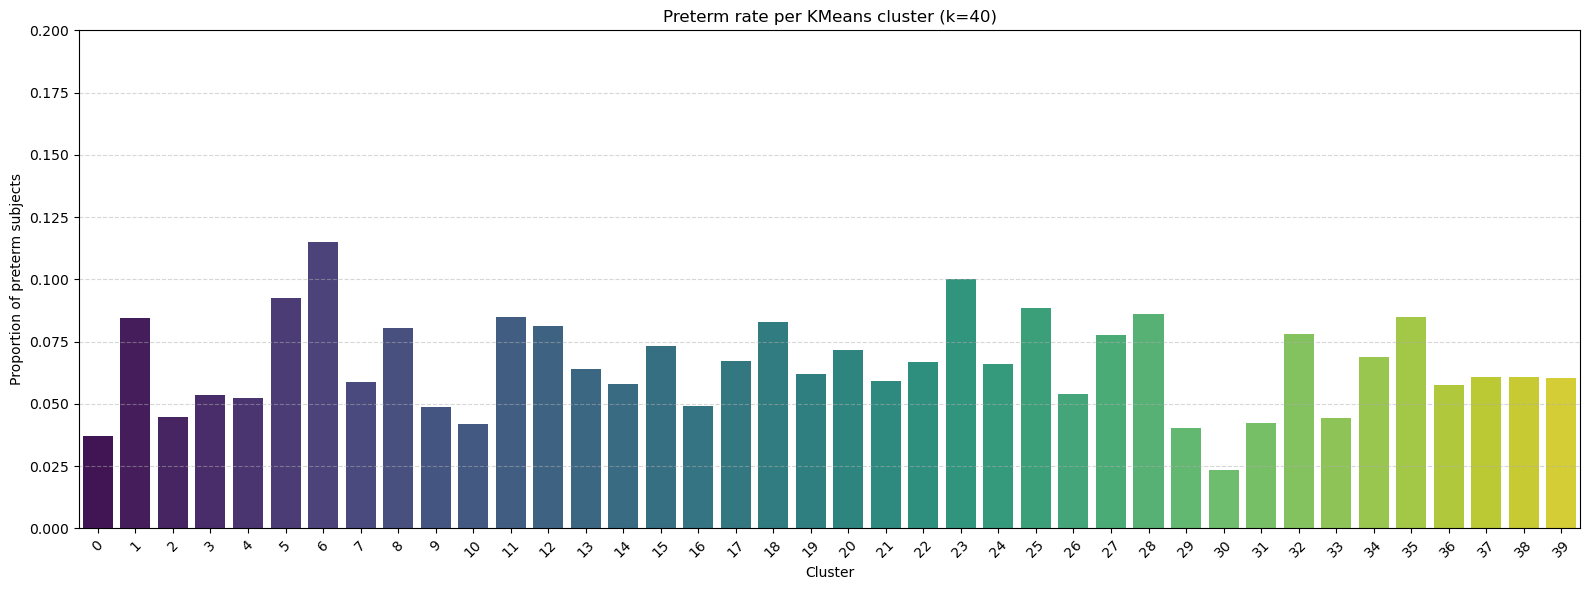

In [253]:
# Clustering with KMeans
n_clusters = 40 # so that we can visualize groups of approximately 250 subjects
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
df['cluster_kmeans'] = kmeans.fit_predict(X)

# Compute the prematurity rate
cluster_stats = (
    df.groupby('cluster_kmeans')['y']
    .agg(['count', 'sum'])
    .rename(columns={'count': 'n_subjects', 'sum': 'n_preterms'})
)
cluster_stats['preterm_rate'] = cluster_stats['n_preterms'] / cluster_stats['n_subjects']

for cluster in cluster_stats.index:
    print(f"Cluster {cluster}: {cluster_stats.loc[cluster, 'n_preterms']} preterm subjects out of {cluster_stats.loc[cluster, 'n_subjects']} ({cluster_stats.loc[cluster, 'preterm_rate']:.2%})")

# Visualisation
plt.figure(figsize=(16, 6))
sns.barplot(x=cluster_stats.index, y=cluster_stats['preterm_rate'],palette='viridis')
plt.ylabel("Proportion of preterm subjects")
plt.xlabel("Cluster")
plt.title("Preterm rate per KMeans cluster (k=40)")
plt.xticks(rotation=45)
plt.ylim(0, 0.2)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [254]:
clustered_df = df[['src_subject_id', 'y', 'cluster_kmeans']].copy()

# Prematurity rates by cluster
preterm_rates = (
    clustered_df.groupby('cluster_kmeans')['y']
    .mean()
    .sort_values(ascending=False)
)

# Create a new column with the rank of prematurity rates
ranked_clusters = {cluster: rank for rank, cluster in enumerate(preterm_rates.index)}
clustered_df['cluster_ranked'] = clustered_df['cluster_kmeans'].map(ranked_clusters)

# Sort the DataFrame by the ranked clusters
clustered_df = clustered_df.sort_values(by=['cluster_ranked'])

# Save the clustered DataFrame to a CSV file
clustered_df.to_csv("clustered_subjects_by_preterm_rate_FCMpost-SpC_right.csv", index=False)
